In [1]:
%load_ext autoreload
%autoreload 2

In [54]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import signal
import seaborn as sns
import sys

sys.path.append("/Users/lukevolpatti/Documents/thesis/signal-decomposition/")
from gfosd import Problem
from gfosd.components import *
from matplotlib import pyplot as plt
import qss

# l1 trend filtering

## Data generation

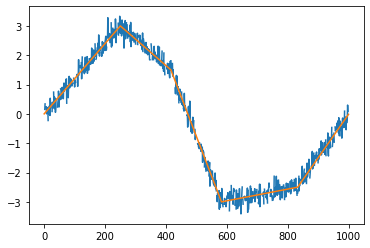

In [68]:
T = int(1e3)
np.random.seed(42)
aa = T // 4
bb = T // 6
pwl = np.r_[
    np.linspace(0, 3, num=aa, endpoint=False),
    np.linspace(3, 1.5, num=bb, endpoint=False),
    np.linspace(1.5, -3, num=bb, endpoint=False),
    np.linspace(-3, -2.5, num=aa, endpoint=False),
    np.linspace(-2.5, 0, num=T - 2 * (aa + bb), endpoint=False),
]
noise = 0.2 * np.random.randn(T)
y = pwl + noise
X_real = np.asarray([noise, pwl])
use_set = np.random.uniform(size=T) >= 0.2
y[~use_set] = np.nan

plt.figure()
plt.plot(y)
plt.plot(pwl)
plt.show();

## Problem formulation

In [69]:
c1 = SumSquare(weight=1 / len(y))
c2 = SumAbs(weight=1, diff=2)
problem = Problem(components=[c1, c2], data=y)
objective_values = {}

## Solutions

### Mosek

In [70]:
problem.decompose(verbose=True, solver="MOSEK")
objective_values["mosek"] = problem.objective_value

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Aug 19 10:26:26 AM: Your problem has 2998 variables, 1 constraints, and 0 parameters.
(CVXPY) Aug 19 10:26:26 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 19 10:26:26 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 19 10:26:26 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 19 10:26:26 AM: Compiling problem (target solver=MOSEK).
(CVXPY) Aug 19 10:26:26 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing

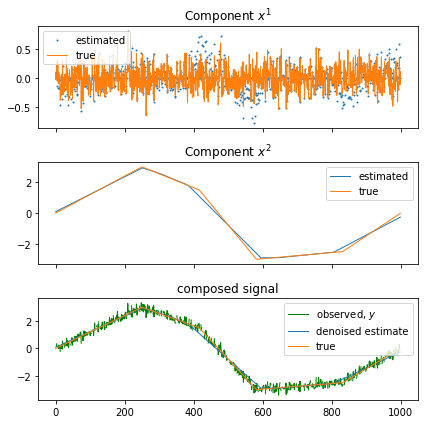

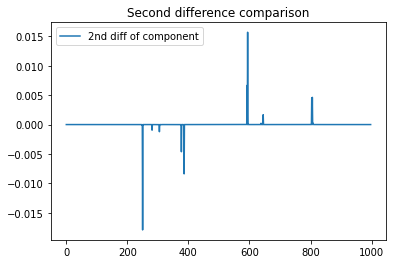

In [71]:
problem.plot_decomposition(X_real=X_real, figsize=(6, 6))
plt.show()

plt.figure()
plt.plot(np.diff(problem.decomposition[1], n=2), label="2nd diff of component")
plt.legend()
plt.title("Second difference comparison")
plt.show()

### QSS

In [72]:
problem.decompose(verbose=True, precond=False, eps_abs=1e-5, eps_rel=1e-5)
objective_values["qss-d"] = problem.objective_value
# calculate a feasible objective value
new_soln = np.copy(problem._qss_soln)
new_soln[2 * T :] = np.diff(problem.decomposition[1], n=2)
new_soln[:T] = problem.mask.zero_fill(y - problem.decomposition[1])
cvx_obj = problem._cvx_obj
cvx_obj.variables()[0].value = new_soln
objective_values["qss-d-feas"] = cvx_obj.objective.value

---------------------------------------------------------------
              QSS: the Quadratic-Separable Solver              
                     author: Luke Volpatti                     
---------------------------------------------------------------
initial factorization time:      2.48e-02s

                           ADMM solve                          
---------------------------------------------------------------
 iter | objective | primal res | dual res |   rho   | time (s) 
---------------------------------------------------------------
    1 | 9.81e-01    1.78e+01     6.00e+00   [0.1 0.1]  4.65e-03
   25 | 4.01e-01    4.07e-01     5.10e-02   [0.1 0.1]  2.21e-02
   50 | 8.37e-01    1.44e+01     6.29e+02   [1.e+06 1.e-06]  4.66e-02
   75 | 1.00e-01    3.61e-02     1.92e+01   [1.e+06 1.e-06]  5.70e-02
  100 | 1.71e+01    4.80e+01     9.71e-02   [5.3031136e-02 1.0000000e-06]  7.19e-02
  125 | 9.41e-01    2.67e-01     1.85e-03   [5.3031136e-02 1.0000000e-06]  8.18e-02
  150 | 

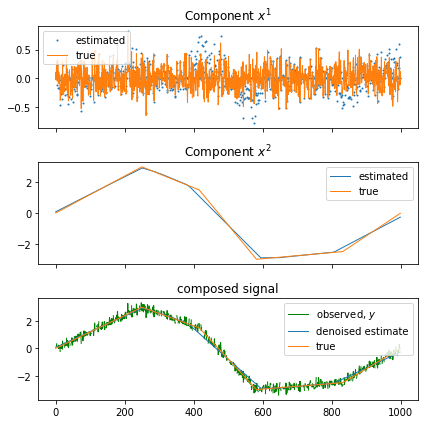

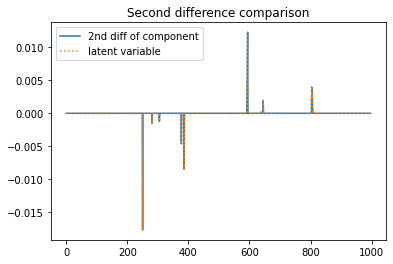

In [61]:
problem.plot_decomposition(X_real=X_real, figsize=(6, 6))
plt.show()

plt.figure()
plt.plot(np.diff(problem.decomposition[1], n=2), label="2nd diff of component")
plt.plot(problem._qss_soln[2 * T :], ls=":", label="latent variable")
plt.legend()
plt.title("Second difference comparison")
plt.show()

# Scaled up l1 trend filtering

## Data generation

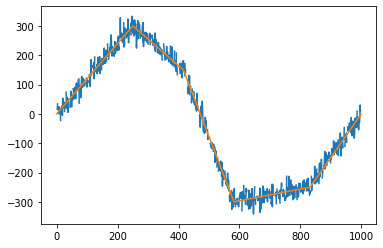

In [62]:
T = int(1e3)
np.random.seed(42)
aa = T // 4
bb = T // 6
pwl = (
    100
    * np.r_[
        np.linspace(0, 3, num=aa, endpoint=False),
        np.linspace(3, 1.5, num=bb, endpoint=False),
        np.linspace(1.5, -3, num=bb, endpoint=False),
        np.linspace(-3, -2.5, num=aa, endpoint=False),
        np.linspace(-2.5, 0, num=T - 2 * (aa + bb), endpoint=False),
    ]
)
noise = 100 * 0.2 * np.random.randn(T)
y = pwl + noise
X_real = np.asarray([noise, pwl])
use_set = np.random.uniform(size=T) >= 0.2
y[~use_set] = np.nan

plt.figure()
plt.plot(y)
plt.plot(pwl)
plt.show();

## Problem formulation

In [63]:
c1 = SumSquare(weight=1 / len(y))
c2 = SumAbs(weight=1, diff=2)
problem = Problem(components=[c1, c2], data=y)
objective_values = {}

## Solutions

### Mosek

In [64]:
problem.decompose(verbose=True, solver="MOSEK")
objective_values["mosek"] = problem.objective_value

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Aug 19 10:23:43 AM: Your problem has 2998 variables, 1 constraints, and 0 parameters.
(CVXPY) Aug 19 10:23:43 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 19 10:23:43 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 19 10:23:43 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 19 10:23:43 AM: Compiling problem (target solver=MOSEK).
(CVXPY) Aug 19 10:23:43 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing

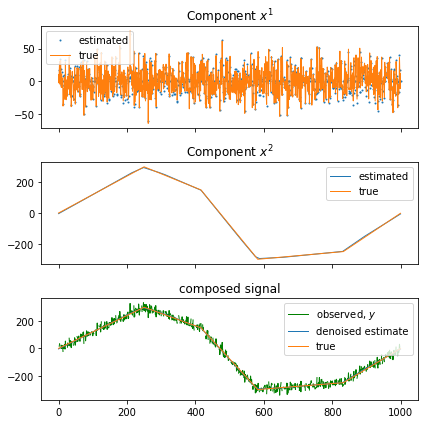

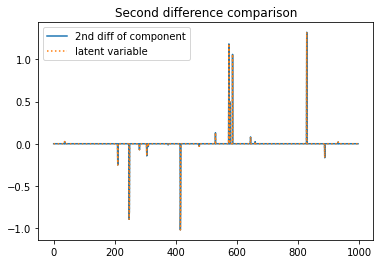

In [12]:
problem.plot_decomposition(X_real=X_real, figsize=(6, 6))
plt.show()

plt.figure()
plt.plot(np.diff(problem.decomposition[1], n=2), label="2nd diff of component")
plt.plot(problem._qss_soln[2 * T :], ls=":", label="latent variable")
plt.legend()
plt.title("Second difference comparison")
plt.show()

### QSS

In [67]:
problem.decompose(verbose=True, precond=False, eps_abs=1e-5, eps_rel=1e-5)
objective_values["qss-d"] = problem.objective_value
# calculate a feasible objective value
new_soln = np.copy(problem._qss_soln)
new_soln[2 * T :] = np.diff(problem.decomposition[1], n=2)
new_soln[:T] = problem.mask.zero_fill(y - problem.decomposition[1])
cvx_obj = problem._cvx_obj
cvx_obj.variables()[0].value = new_soln
objective_values["qss-d-feas"] = cvx_obj.objective.value

---------------------------------------------------------------
              QSS: the Quadratic-Separable Solver              
                     author: Luke Volpatti                     
---------------------------------------------------------------
initial factorization time:      8.74e-03s

                           ADMM solve                          
---------------------------------------------------------------
 iter | objective | primal res | dual res |   rho   | time (s) 
---------------------------------------------------------------
    1 | 1.82e+04    1.72e+03     6.02e+02   [0.1 0.1]  6.93e-04
   25 | 4.08e+03    1.61e+01     3.44e+00   [0.1 0.1]  2.33e-02
   50 | 6.18e+02    1.43e+03     7.61e+00   [1.00376457e+01 1.00000000e-06]  5.25e-02
   75 | 1.61e+02    3.96e-01     4.04e-01   [1.00376457e+01 1.00000000e-06]  7.98e-02
  100 | 1.61e+02    2.28e-01     1.38e-01   [6.18804243e-01 1.00000000e-06]  1.15e-01
  125 | 1.61e+02    6.89e-02     2.04e-02   [6.18804243e-0

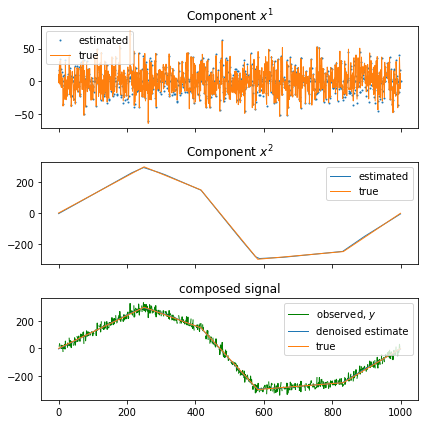

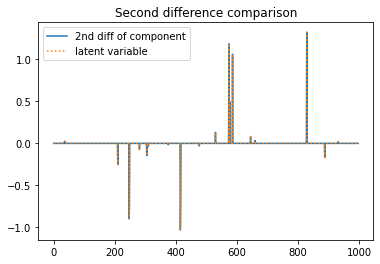

In [14]:
problem.plot_decomposition(X_real=X_real, figsize=(6, 6))
plt.show()

plt.figure()
plt.plot(np.diff(problem.decomposition[1], n=2), label="2nd diff of component")
plt.plot(problem._qss_soln[2 * T :], ls=":", label="latent variable")
plt.legend()
plt.title("Second difference comparison")
plt.show()

# Long l1 trend filtering

## Data generation

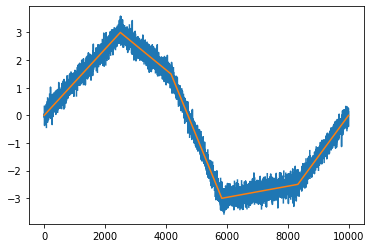

In [73]:
T = int(1e4)
np.random.seed(42)
aa = T // 4
bb = T // 6
pwl = np.r_[
    np.linspace(0, 3, num=aa, endpoint=False),
    np.linspace(3, 1.5, num=bb, endpoint=False),
    np.linspace(1.5, -3, num=bb, endpoint=False),
    np.linspace(-3, -2.5, num=aa, endpoint=False),
    np.linspace(-2.5, 0, num=T - 2 * (aa + bb), endpoint=False),
]
noise = 0.2 * np.random.randn(T)
y = pwl + noise
X_real = np.asarray([noise, pwl])
use_set = np.random.uniform(size=T) >= 0.2
y[~use_set] = np.nan

plt.figure()
plt.plot(y)
plt.plot(pwl)
plt.show();

## Problem formulation

In [74]:
c1 = SumSquare(weight=1 / len(y))
c2 = SumAbs(weight=1, diff=2)
problem = Problem(components=[c1, c2], data=y)
objective_values = {}

## Solutions

### OSQP (CVXPY takes too long to canonicalize this problem to MOSEK)

In [75]:
problem.decompose(verbose=True, solver="OSQP")
objective_values["osqp"] = problem.objective_value

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Aug 19 10:26:58 AM: Your problem has 29998 variables, 1 constraints, and 0 parameters.
(CVXPY) Aug 19 10:26:58 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 19 10:26:58 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 19 10:26:58 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 19 10:26:58 AM: Compiling problem (target solver=OSQP).
(CVXPY) Aug 19 10:26:58 AM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuff

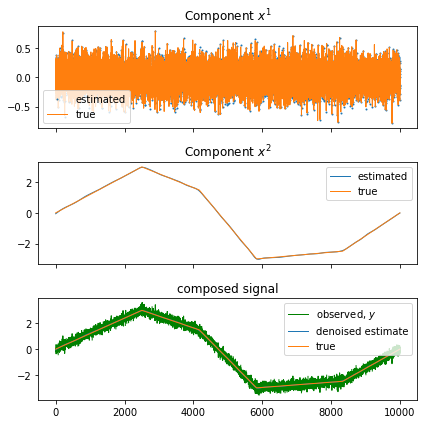

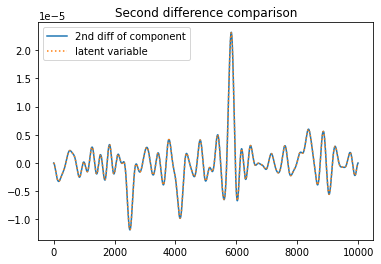

In [76]:
problem.plot_decomposition(X_real=X_real, figsize=(6, 6))
plt.show()

plt.figure()
plt.plot(np.diff(problem.decomposition[1], n=2), label="2nd diff of component")
plt.plot(problem._qss_soln[2 * T :], ls=":", label="latent variable")
plt.legend()
plt.title("Second difference comparison")
plt.show()

### QSS

In [77]:
problem.decompose(verbose=True, precond=False, eps_abs=1e-5, eps_rel=1e-5)
objective_values["qss-d"] = problem.objective_value
# calculate a feasible objective value
new_soln = np.copy(problem._qss_soln)
new_soln[2 * T :] = np.diff(problem.decomposition[1], n=2)
new_soln[:T] = problem.mask.zero_fill(y - problem.decomposition[1])
cvx_obj = problem._cvx_obj
cvx_obj.variables()[0].value = new_soln
objective_values["qss-d-feas"] = cvx_obj.objective.value

---------------------------------------------------------------
              QSS: the Quadratic-Separable Solver              
                     author: Luke Volpatti                     
---------------------------------------------------------------
initial factorization time:      5.04e-02s

                           ADMM solve                          
---------------------------------------------------------------
 iter | objective | primal res | dual res |   rho   | time (s) 
---------------------------------------------------------------
    1 | 9.85e-01    5.63e+01     1.89e+01   [0.1 0.1]  2.24e-03
   25 | 5.25e-01    1.31e+00     1.80e-01   [0.1 0.1]  5.32e-02
   50 | 8.81e-02    5.80e+01     8.96e+01   [1.e+06 1.e-06]  1.13e-01
   75 | 2.39e-02    8.84e-03     2.67e+00   [1.e+06 1.e-06]  1.52e-01
  100 | 1.57e+00    1.37e+01     2.99e-02   [3.03266104e-01 1.00000000e-06]  2.19e-01
  125 | 9.73e-02    4.64e-02     3.12e-04   [3.03266104e-01 1.00000000e-06]  2.64e-01
  15

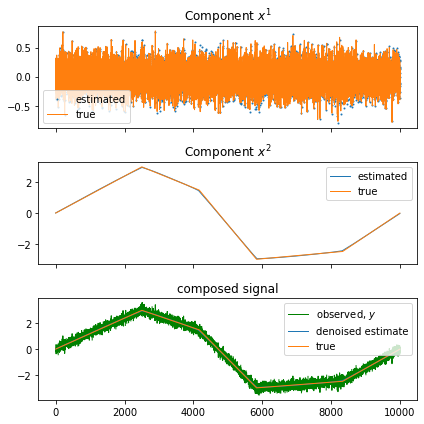

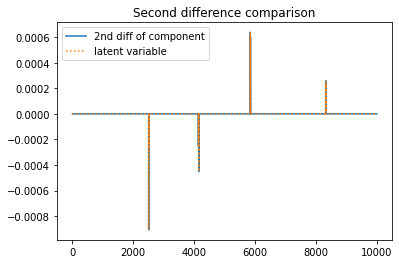

In [78]:
problem.plot_decomposition(X_real=X_real, figsize=(6, 6))
plt.show()

plt.figure()
plt.plot(np.diff(problem.decomposition[1], n=2), label="2nd diff of component")
plt.plot(problem._qss_soln[2 * T :], ls=":", label="latent variable")
plt.legend()
plt.title("Second difference comparison")
plt.show()

# Denoising smooth signal

## Data generation

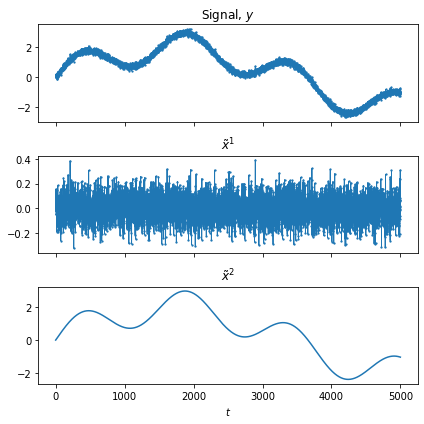

In [21]:
np.random.seed(42)

T = np.linspace(0, 1, 5000)
scale = 0.7816 * 5
rho = 0.75

x1_real = np.random.randn(len(T)) * 0.1

num_sines = 3
phases = np.random.uniform(low=0, high=2 * np.pi, size=num_sines)
frequencies = np.random.uniform(low=1, high=5, size=num_sines)
params = zip(frequencies, phases)
x2_real = np.sum([np.sin(T * 2 * f * +ph) for f, ph in params], axis=0)

num_sines = 7
phases = np.random.uniform(low=0, high=2 * np.pi, size=num_sines)
frequencies = np.random.uniform(low=30, high=32, size=num_sines)
params = zip(frequencies, phases)

X_real = np.array([x1_real, x2_real])
y = np.sum(X_real, axis=0)

fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(6, 6))  # (10, 8))
ax[0].plot(y, linewidth=0.9, marker=".", markersize=2.5)
ax[1].plot(x1_real, linewidth=0.9, marker=".", markersize=2.5)
ax[2].plot(x2_real)
ax[0].set_title("Signal, $y$")
for i in range(X_real.shape[0]):
    ax[i + 1].set_title("$\\tilde{x}^{" + "{}".format(i + 1) + "}$")
ax[-1].set_xlabel("$t$")
plt.tight_layout()
T = len(T)

## Problem formulation

In [22]:
c1 = SumSquare(weight=1 / len(y))
c2 = SumSquare(weight=10, diff=2)
problem = Problem(components=[c1, c2], data=y)
objective_values = {}

## Solutions

### OSQP

In [23]:
problem.decompose(verbose=True, solver="OSQP")
objective_values["osqp"] = problem.objective_value

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Aug 18 08:25:30 PM: Your problem has 14998 variables, 1 constraints, and 0 parameters.
(CVXPY) Aug 18 08:25:30 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 18 08:25:30 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 18 08:25:30 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 18 08:25:30 PM: Compiling problem (target solver=OSQP).
(CVXPY) Aug 18 08:25:30 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuff

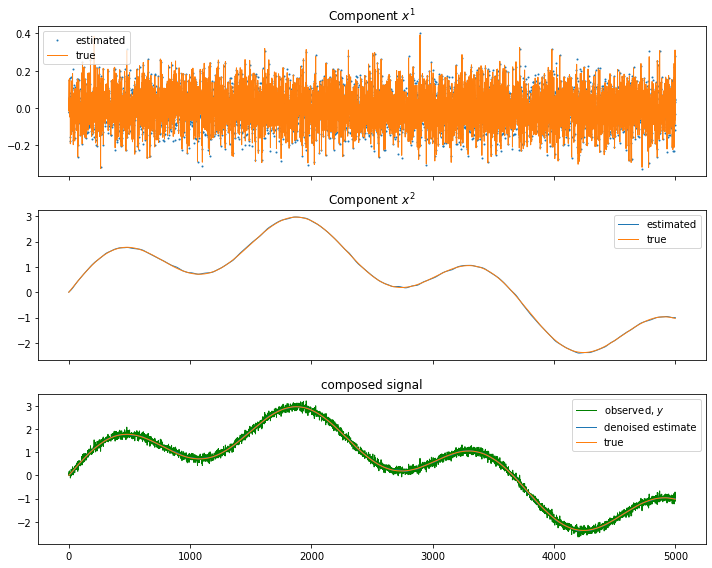

In [24]:
fig = problem.plot_decomposition(X_real=X_real)
plt.show()

### QSS

In [25]:
problem.decompose(verbose=True, precond=False, eps_abs=1e-5, eps_rel=1e-5)

new_soln = np.copy(problem._qss_soln)
new_soln[2 * T :] = np.diff(problem.decomposition[1], n=2)
new_soln[:T] = problem.mask.zero_fill(y - problem.decomposition[1])
cvx_obj = problem._cvx_obj
cvx_obj.variables()[0].value = new_soln
objective_values["qss"] = cvx_obj.objective.value

---------------------------------------------------------------
              QSS: the Quadratic-Separable Solver              
                     author: Luke Volpatti                     
---------------------------------------------------------------
initial factorization time:      4.12e-02s

                           ADMM solve                          
---------------------------------------------------------------
 iter | objective | primal res | dual res |   rho   | time (s) 
---------------------------------------------------------------
    1 | 6.80e-01    3.12e+01     1.09e+01   [0.1]  1.51e-03
   25 | 2.86e-01    3.01e-02     1.06e-02   [0.1]  3.81e-02
   50 | 4.41e-02    2.87e+01     1.01e-04   [1.e-06]  1.21e-01
   60 | 4.84e-03    2.12e-03     7.41e-09   [1.e-06]  1.81e-01
---------------------------------------------------------------
avg time per iter:               2.70e-03s
refactorizations:                1
total time spent refactorizing:  2.08e-02s

objective va

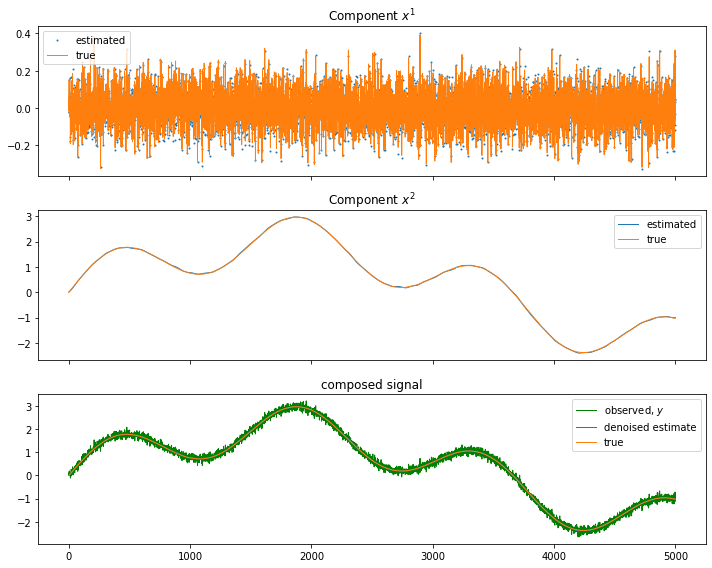

In [26]:
fig = problem.plot_decomposition(X_real=X_real)
plt.show()

# Smooth plus piecewise constant

## Data generation

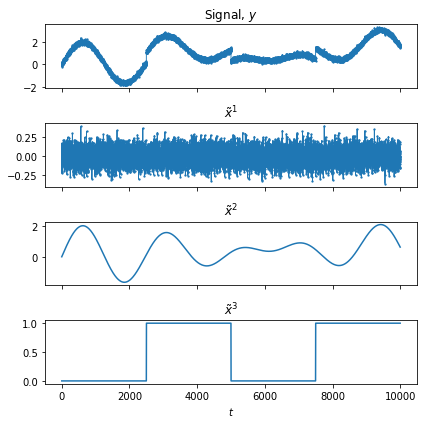

In [79]:
np.random.seed(1)
T = int(1e4)

x1_real = 0.1 * np.random.randn(T)

num_sines = 3
phases = np.random.uniform(low=0, high=2 * np.pi, size=num_sines)
frequencies = np.random.uniform(low=1, high=5, size=num_sines)
params = zip(frequencies, phases)
x2_real = np.sum(
    [np.sin(np.linspace(0, 1, T) * 2 * f * +ph) for f, ph in params], axis=0
)

patterns = 1 * np.array([0, 1, 0, 1])
x3_real = np.repeat(patterns, T / len(patterns))

X_real = np.array([x1_real, x2_real, x3_real])
y = np.sum(X_real, axis=0)

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(6, 6))  # (10, 8))
ax[0].plot(y, linewidth=0.9, marker=".", markersize=2.5)
ax[1].plot(x1_real, linewidth=0.9, marker=".", markersize=2.5)
ax[2].plot(x2_real)
ax[3].plot(x3_real)
ax[0].set_title("Signal, $y$")
for i in range(X_real.shape[0]):
    ax[i + 1].set_title("$\\tilde{x}^{" + "{}".format(i + 1) + "}$")
ax[-1].set_xlabel("$t$")
plt.tight_layout()

## Problem formulation

In [80]:
c1 = SumSquare(weight=1 / len(y))
c2 = SumSquare(weight=100, diff=2)
c3 = SumAbs(weight=0.0001, diff=1)
problem = Problem(components=[c1, c2, c3], data=y)
objective_values = {}

## Solutions

### OSQP

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Aug 19 10:29:19 AM: Your problem has 49997 variables, 1 constraints, and 0 parameters.
(CVXPY) Aug 19 10:29:19 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 19 10:29:19 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 19 10:29:19 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 19 10:29:19 AM: Compiling problem (target solver=OSQP).
(CVXPY) Aug 19 10:29:19 AM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuff

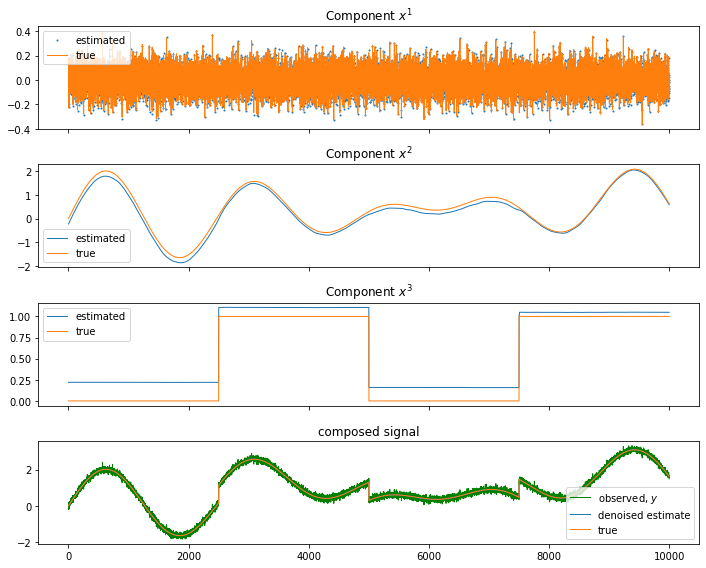

In [81]:
problem.decompose(verbose=True, solver="OSQP")
objective_values["osqp"] = problem.objective_value

fig = problem.plot_decomposition(X_real=X_real)
plt.show()

### QSS

---------------------------------------------------------------
              QSS: the Quadratic-Separable Solver              
                     author: Luke Volpatti                     
---------------------------------------------------------------
initial factorization time:      6.47e-02s

                           ADMM solve                          
---------------------------------------------------------------
 iter | objective | primal res | dual res |   rho   | time (s) 
---------------------------------------------------------------
    1 | 3.17e-01    3.34e+01     1.17e+01   [0.1 0.1]  3.11e-03
   25 | 1.27e-01    2.65e-02     8.74e-03   [0.1 0.1]  6.53e-02
   50 | 2.60e-02    2.22e+01     9.68e-03   [1.e-01 1.e-06]  1.68e-01
   75 | 5.92e-03    3.89e-01     2.88e-03   [1.e-01 1.e-06]  3.23e-01
  100 | 5.35e-03    2.15e-01     9.19e-04   [1.e-01 1.e-06]  4.08e-01
  125 | 5.28e-03    7.42e-02     3.45e-04   [1.e-01 1.e-06]  4.66e-01
  150 | 5.27e-03    2.80e-02     1.7

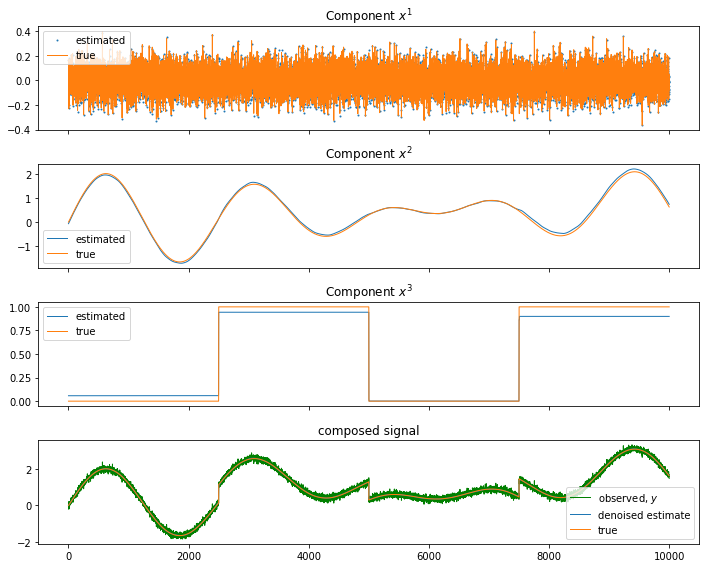

In [82]:
problem.decompose(verbose=True, precond=False, eps_abs=1e-5, eps_rel=1e-5)
objective_values["qss"] = problem.objective_value

fig = problem.plot_decomposition(X_real=X_real)
plt.show()

# Triangle wave plus sine wave, periodic

## Data generation

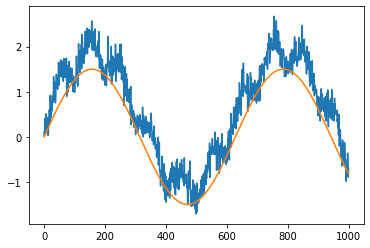

In [83]:
T = int(1e3)
np.random.seed(42)

triangle = 0.8 * np.tile(sp.signal.triang(T / 10), 10)
noise = 0.2 * np.random.randn(T)
x2_real = 1.5 * np.sin(np.linspace(0, 1, T) * 10)

y = noise + x2_real + triangle
X_real = np.asarray([noise, x2_real, triangle])

plt.figure()
plt.plot(y)
plt.plot(x2_real)
plt.show();

## Problem formulation

Note: we add a very small sum of squares penalty on the 0th difference of the c2 and c3 components to ensure uniqueness of decomposition. 

In [84]:
c1 = SumSquare(weight=1 / len(y))
c2 = Aggregate(
    [
        SumSquare(weight=0.01 / len(y)),
        SumSquare(weight=10, diff=2),
        Periodic(period=200 * np.pi, T=T),
    ]
)
c3 = Aggregate(
    [
        SumSquare(weight=0.01 / len(y)),
        SumAbs(weight=1 / 1000, diff=2),
        Periodic(period=T / 10, T=T),
    ]
)
problem = Problem(components=[c1, c2, c3], data=y)
objective_values = {}

## Solutions

### OSQP

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Aug 19 10:30:04 AM: Your problem has 5724 variables, 1 constraints, and 0 parameters.
(CVXPY) Aug 19 10:30:04 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 19 10:30:04 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 19 10:30:04 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 19 10:30:04 AM: Compiling problem (target solver=OSQP).
(CVXPY) Aug 19 10:30:04 AM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffi

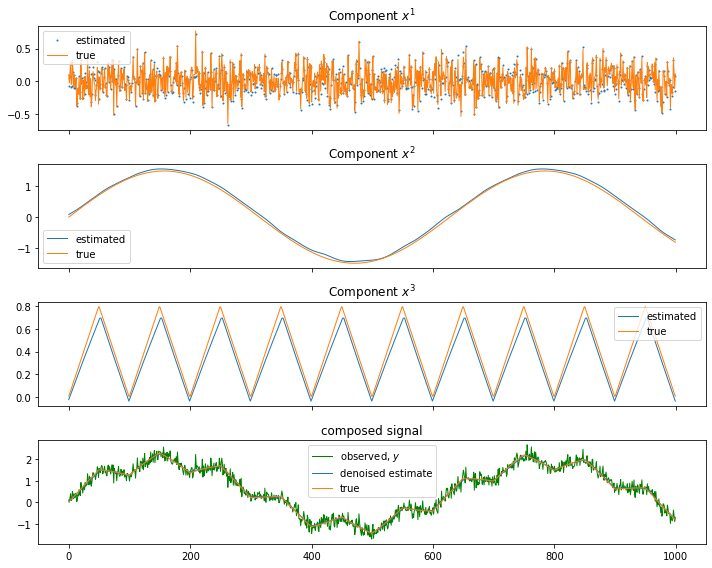

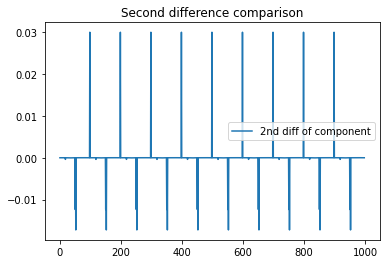

In [85]:
problem.decompose(verbose=True, solver="OSQP")
objective_values["osqp"] = problem.objective_value

fig = problem.plot_decomposition(X_real=X_real)
plt.show()

plt.figure()
plt.plot(np.diff(problem.decomposition[2], n=2), label="2nd diff of component")
plt.legend()
plt.title("Second difference comparison")
plt.show()

### QSS

---------------------------------------------------------------
              QSS: the Quadratic-Separable Solver              
                     author: Luke Volpatti                     
---------------------------------------------------------------
initial factorization time:      7.47e-02s

                           ADMM solve                          
---------------------------------------------------------------
 iter | objective | primal res | dual res |   rho   | time (s) 
---------------------------------------------------------------
    1 | 5.38e-01    1.18e+01     4.12e+00   [0.1 0.1]  5.29e-03
   25 | 1.98e-01    5.01e-02     1.68e-02   [0.1 0.1]  3.42e-02
   50 | 4.62e-02    1.04e+01     2.62e-02   [2.53115066e+00 1.00000000e-06]  6.28e-02
   75 | 2.56e-02    8.99e-04     1.25e-03   [2.53115066e+00 1.00000000e-06]  7.79e-02
  100 | 2.56e-02    2.39e-03     5.21e-04   [1.67976062e-01 1.00000000e-06]  9.71e-02
  125 | 2.56e-02    5.21e-04     1.43e-04   [1.67976062e-0

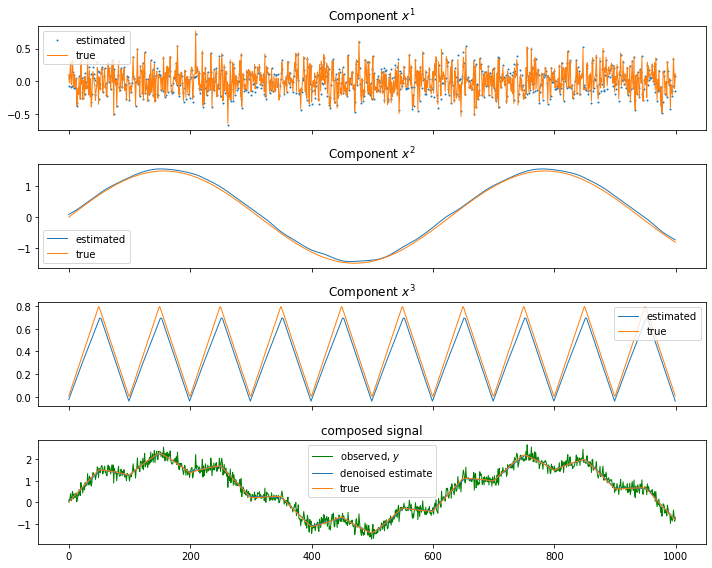

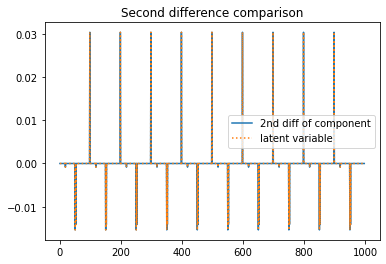

In [86]:
problem.decompose(
    verbose=True,
    precond=False,
    eps_abs=1e-6,
    eps_rel=1e-6,
    max_iter=1000,
    adaptive_rho=True,
)

problem.plot_decomposition(X_real=X_real)
plt.show()

plt.figure()
plt.plot(np.diff(problem.decomposition[2], n=2), label="2nd diff of component")
plt.plot(
    problem._qss_soln[-(T - 2 + T // 10) : -T // 10], ls=":", label="latent variable"
)
plt.legend()
plt.title("Second difference comparison")
plt.show()

In [35]:
data = problem.make_graph_form()
r = data["A"] @ problem._qss_soln - data["b"]
actual_primal_infeas = np.sum(np.sqrt(np.average(np.square(r))))
actual_primal_infeas = np.linalg.norm(r)
print(f"{actual_primal_infeas = :.4e}")

actual_primal_infeas = 2.3620e-05
